## Importing required libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split , StratifiedKFold,GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score,recall_score , precision_score,make_scorer,confusion_matrix,precision_recall_curve,mean_squared_error
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import SVR
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1 : Predicting the outcome of a new patient

##1. Loading the data

In [2]:
df=pd.read_csv('data.csv')

#2. Data preprocessing

In [3]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [4]:
df.isnull().sum()  # checking for null values 

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [5]:
df=df.drop(['Unnamed: 32'],axis=1)

#3.Visualizing data

##a). Checking for outliers by plotting boxplot taking 10 features at a time

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

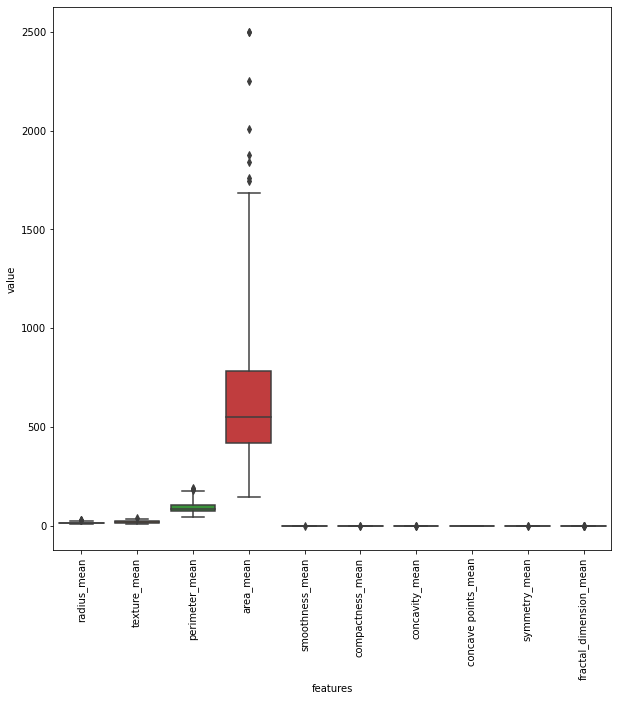

In [6]:
# for mean features

data = pd.concat([df.diagnosis,df.iloc[:,2:12]],axis=1)
data = pd.melt(data,id_vars="diagnosis",var_name="features",value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value",whis=2.5, data=data)
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

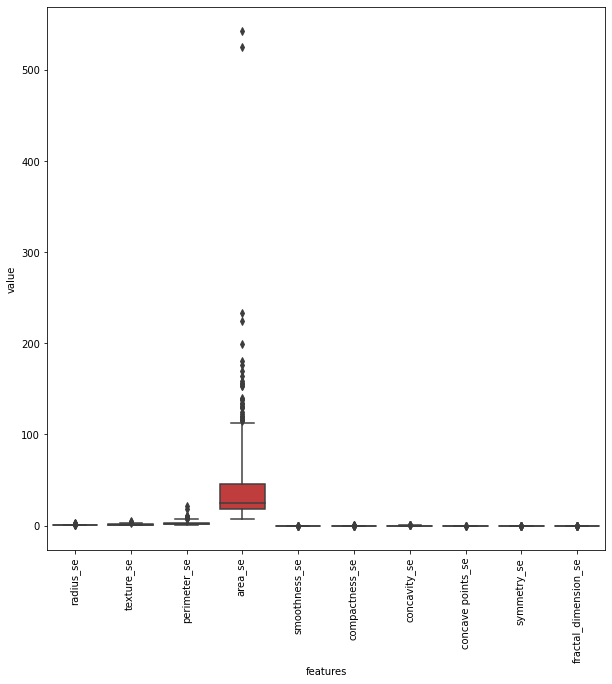

In [7]:
#for std_dev features

data2 = pd.concat([df.diagnosis,df.iloc[:,12:22]],axis=1)
data2 = pd.melt(data2,id_vars="diagnosis",var_name="features",value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", whis=2.5,data=data2)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

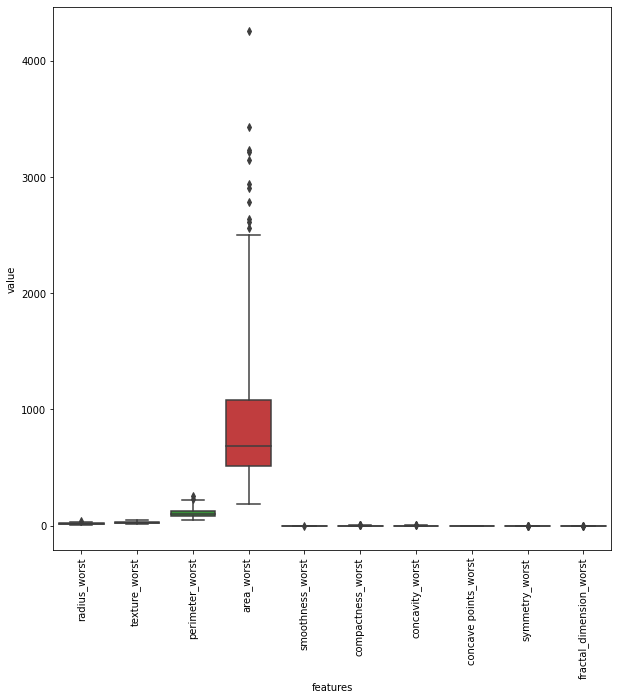

In [8]:
# for worst features

data3 = pd.concat([df.diagnosis,df.iloc[:,22:32]],axis=1)
data3 = pd.melt(data3,id_vars="diagnosis",var_name="features",value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", whis=2.5,data=data3)
plt.xticks(rotation=90)

By looking at above 3 plots , we will clip the area parameters .


In [9]:
df=df[df.area_mean<2000]
df=df[df.area_se<300]
df=df[df.area_worst<4000]
df.shape

(565, 32)

##b). Checking correlation between features by plotting heatmap



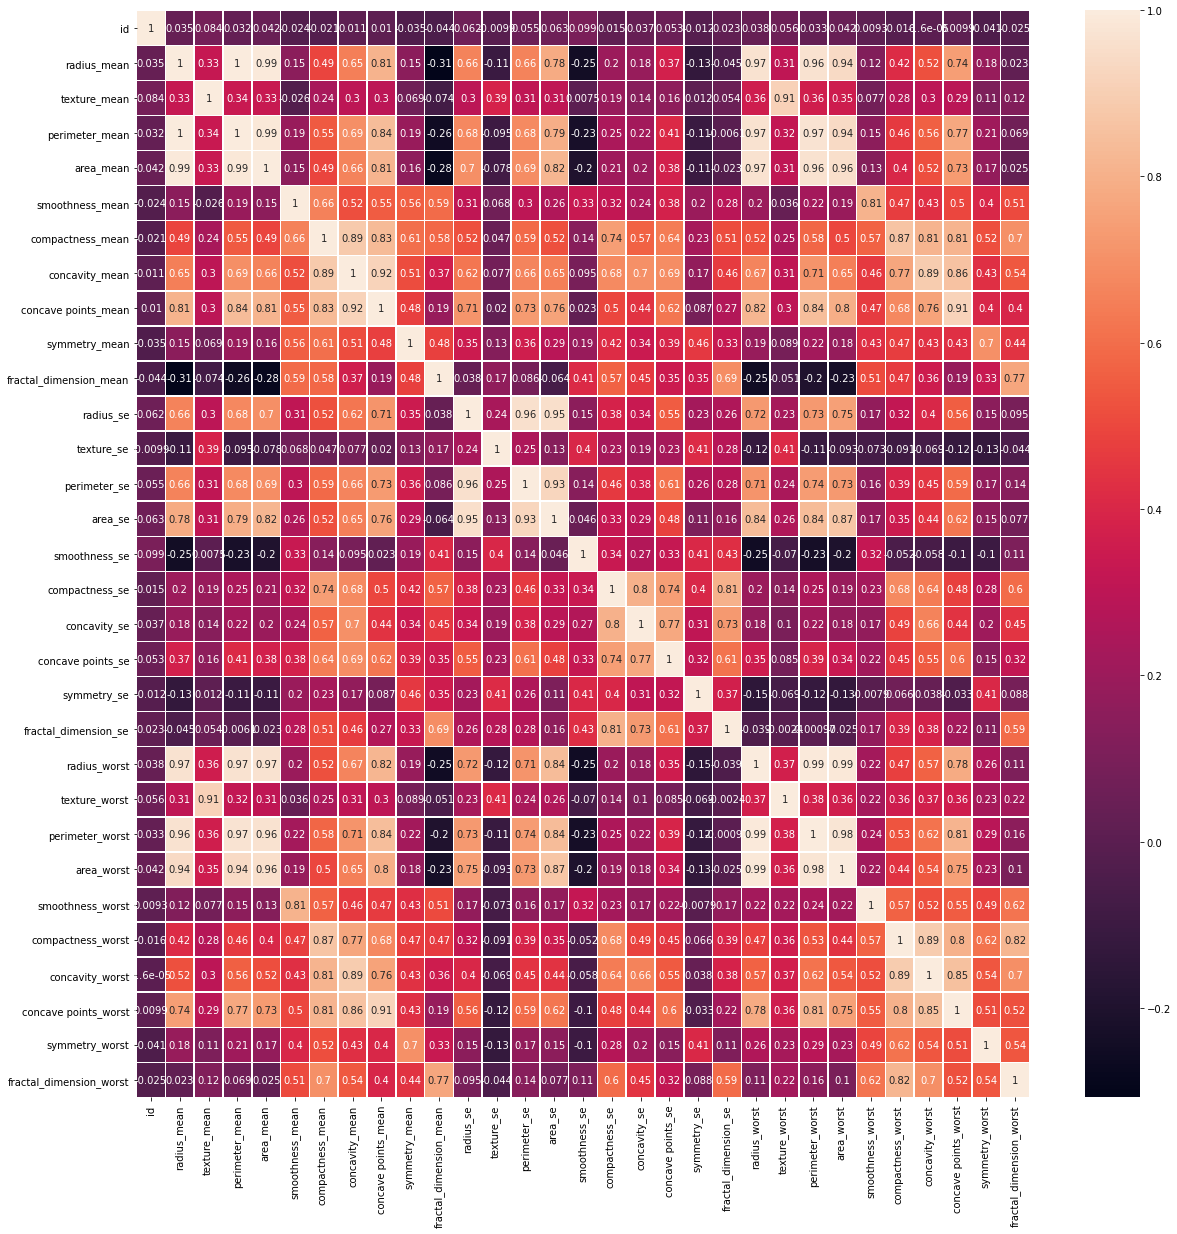

In [10]:
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot=True,linewidths=.5, fmt= '.2g',ax=ax)

#4. Feature selection

In [11]:
#correlation between all mean and worst features

cols_mean=list(df.columns)[2:12]
cols_worst=list(df.columns)[22:32]
for i in range(0,10):
    corr, _ = pearsonr(df[cols_mean[i]],df[cols_worst[i]])
    print(cols_mean[i],'-',cols_worst[i],'=',corr)

radius_mean - radius_worst = 0.9689658390669278
texture_mean - texture_worst = 0.9130818685375928
perimeter_mean - perimeter_worst = 0.9700250683057541
area_mean - area_worst = 0.9588972392256557
smoothness_mean - smoothness_worst = 0.8086027558708953
compactness_mean - compactness_worst = 0.8665339765115452
concavity_mean - concavity_worst = 0.8912007065566829
concave points_mean - concave points_worst = 0.9131920342945539
symmetry_mean - symmetry_worst = 0.7017471061798988
fractal_dimension_mean - fractal_dimension_worst = 0.7669947081062761


As we can see in heatmap compactness_mean, concavity_mean and concave_points_mean are correlated with each other so we remove compactness_mean and concave_points_mean also area_mean, perimeter_mean and radius_mean are correlated with each other so we keep only area_mean .Similarly we remove compactness_se,concave points_se and keep concavity_se , remove  radius_std_dev, perimeter_std_dev
and keep only area_std_dev , remove compactness_worst, concave_points__worst and keep only concavity_worst , remove radius_worst , perimeter_worst and keep only area_worst.

In [12]:
#dropping unwanted features as discussed above 

drop_list = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
df=df.drop(drop_list,axis=1)

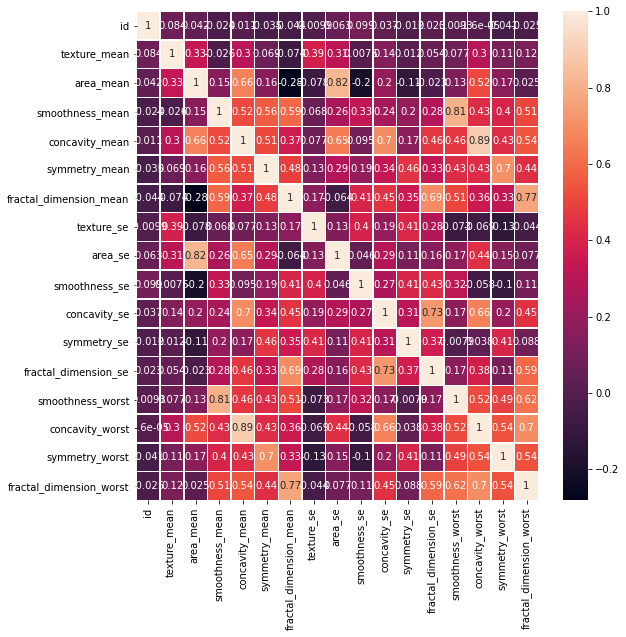

In [13]:
f1,ax1 = plt.subplots(figsize=(9,9))
sns.heatmap(df.corr(), annot=True,linewidths=.5, fmt= '.2g',ax=ax1)  # after removing correlated features

#5.Model selection and validation

We are splitting the given data in the ratio 7:3 or we can say 70% is our training data and rest 30% is our test data on which we will make predictions , calculate accuracy and submit the results 

In [14]:
# splitting the data  

Y=df['diagnosis']      # target variable
en=LabelEncoder()
Y=en.fit_transform(Y)   # encode 'N' to 0 and 'R' to 1
X=df.drop(['diagnosis'],axis=1)
X_train , X_test , y_train , y_test=train_test_split(X,Y,test_size=0.3,random_state=44)
ids1=X_test['id']
X_train=X_train.drop(['id'],axis=1)       # training data
X_test=X_test.drop(['id'],axis=1)         # test data

We have to minimize false negatives(FN) because predicting the disease even if it is not present is less risky as compared to predicting disease free but actually it is present 
Or we can say we have to maximise recall score of our classifier which is formulated as :

            Recall = TP/(TP+FN)

In [15]:
# we are building custom function which fits the model with best hyperparametrs using grid search , calculates accuracy and recall score
# We optimize our model to maximize recall score
# It also plots precision recall curve and confusion matrix 

def fit_model(model,Xtrain,Xtest,ytrain,ytest,features,param_grid):
  scorers = {'recall_score': make_scorer(recall_score)}
  kf = StratifiedKFold(n_splits=3)
  grids = GridSearchCV(model,param_grid,scoring=scorers, refit='recall_score',cv=kf)
  grids.fit(Xtrain[features],ytrain)
  pred = grids.predict(Xtest)
  print('Best parameters:',grids.best_params_)
  accuracy = accuracy_score(pred,ytest)
  print('Accuracy :',accuracy)
  rscore=recall_score(ytest, pred, average='binary')
  print('Recall-score:',rscore)
  fpr, tpr, thresholds = precision_recall_curve(ytest, pred)
  plt.subplot(1,2,1)
  plt.plot(fpr,tpr, marker='.')
  cm = confusion_matrix(ytest,pred)
  plt.subplot(1,2,2)
  sns.heatmap(cm,annot=True,fmt="d")
  return grids
  

a) Using logistic regression

Since target variable is binary hence our first approach would be Logistic Regression

Best parameters: {'C': 1, 'max_iter': 100}
Accuracy : 0.9294117647058824
Recall-score: 0.864406779661017


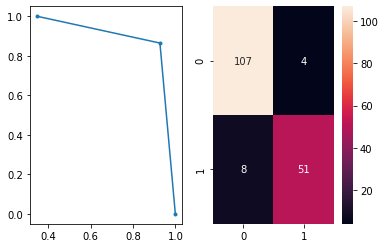

In [16]:
feats = X_train.columns
ss= MinMaxScaler(feature_range=(0,1))  # scaling features for logistic regression
X_train1=pd.DataFrame(ss.fit_transform(X_train),columns=feats)
X_test1=pd.DataFrame(ss.fit_transform(X_test),columns=feats)
param_grid = {'C': [1],'max_iter':[100,200,300]}

lr=LogisticRegression(random_state=8)
fitted=fit_model(lr,X_train1,X_test1,y_train,y_test,feats,param_grid)


b) Using random forests

Best parameters: {'max_depth': 7, 'max_features': 9, 'min_samples_split': 4, 'n_estimators': 80}
Accuracy : 0.9352941176470588
Recall-score: 0.9491525423728814


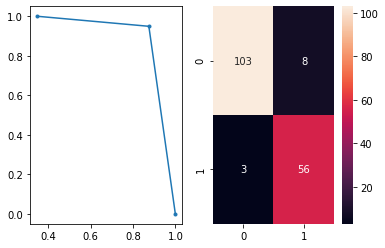

In [17]:
feats = X_train.columns
param_grid1 = {'n_estimators': [70,80],'min_samples_split':[4,5],'max_depth':[7,9],'max_features':[9]}
rf = RandomForestClassifier(random_state=8)
grid_search_clf=fit_model(rf,X_train,X_test,y_train,y_test,feats,param_grid1)

c) By adjusting decision threshold of above Random forest model (default is 0.5)

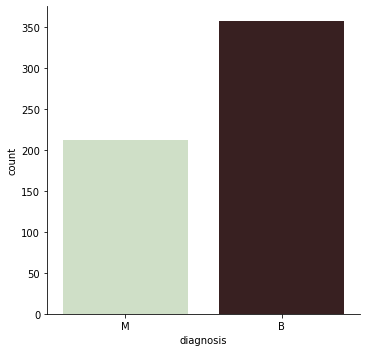

In [19]:
#checking class distribution

df2 = pd.read_csv('data.csv') 
sns.catplot(x="diagnosis", kind="count", palette="ch:.75", data=df2);


As we can see in above plot , our data is class imbalanced hence predictions would be much baised towards 'B' class.
So we can tune our classification threshold for random forest
untill we get minimum False negatives 

In [20]:
y_probs = grid_search_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_probs)


def threshold_tuner(y_scores, t):    # for setting threshold
    
    return [1 if y >= t else 0 for y in y_scores]

def confusion_m(p, r, thresholds, t):     # plot confusion matrix after setting threshold and return new predictions
    
    y_pred_adj = threshold_tuner(y_probs, t)
    cm1 = confusion_matrix(y_test,y_pred_adj)
    sns.heatmap(cm1,annot=True,fmt="d")    
    predicted=y_pred_adj
    print('Accuracy:',accuracy_score(predicted,y_test))
    return predicted

We will tune the threshold until false negatives reach minimum

Accuracy: 0.9352941176470588


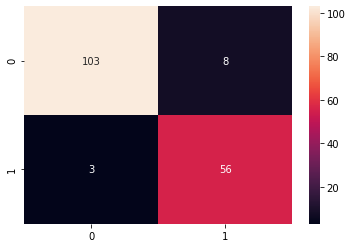

In [26]:
pr=confusion_m(p, r, thresholds, 0.49)

So our optimum threshold is t=0.49

In [27]:
#Reverse encoding 1 to 'M' and 0 to 'B'

task1_pred=[]             
for x in range(0,len(pr)):
  if pr[x]==0:
    task1_pred.append('B')
  elif pr[x]==1:
    task1_pred.append('M')


In [29]:
# creating csv file of test predictions

sub1 = pd.DataFrame({"ID": ids1, "Outcome": task1_pred})
sub1.to_csv('pred.csv', index=False)